In [1]:
import torch.nn as nn
import torch
import torchvision.datasets
from torch import Tensor
from milankalkenings.modules import Module
import math
import matplotlib.pyplot as plt

In [2]:
class Block(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, do_residual: bool):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_ch,
                              out_channels=out_ch,
                              kernel_size=3,
                              padding=1)
        self.rect = nn.ReLU()
        self.pool = nn.FractionalMaxPool2d(kernel_size=2, output_ratio=1 / math.sqrt(2))

        # residual
        self.do_residual = do_residual
        self.re_zero = nn.Parameter(data=torch.tensor(0).float())
        self.coupler = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1)

    def forward(self, x: Tensor) -> Tensor:
        non_linear = self.re_zero * self.rect(self.conv(x))
        if self.do_residual:

            residual = self.re_zero * self.coupler(x)
            out = self.pool(non_linear + residual)
        else:
            out = self.pool(non_linear)
        return out


class StabilityLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, obs_scores: Tensor) -> Tensor:
        loss = 0
        for i in range(len(obs_scores) - 1):
            for j in range(i, len(obs_scores)):
                if i != j:
                    loss += torch.norm(obs_scores[i] - obs_scores[j]) ** 2
        return loss


class MutualExclusivityLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, probs: Tensor):
        """
        n: samples
        t : classes
        k: classes without (current) class t
        \sum_n(-\sum_t(prob_t*\prod_k(1-prob_k)))
        """
        loss = 0
        for obs_cls_probs in probs:
            obs_loss = 0
            for i in range(len(obs_cls_probs)):
                obs_loss += obs_cls_probs[i]
                for j in range(len(obs_cls_probs)):
                    if i != j:
                        obs_loss *= (1 - obs_cls_probs[j])
            loss -= obs_loss
        return loss / len(probs)  # avg makes it agnostic to batch size


class Classifier(Module):
    def __init__(
            self,
            n_blocks: int,
            dropout_p: float = 0.5,
            n_forwards: int = 4,
            st_loss_weight: float = 1,
            me_loss_weight: float = 1,
            do_residual: bool = True):
        super().__init__()
        self.n_forwards = n_forwards
        self.me_loss_weight = me_loss_weight
        self.st_loss_weight = st_loss_weight
        self.blocks = nn.ModuleList()
        self.blocks.append(nn.Dropout(p=dropout_p))
        self.blocks.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=1))
        for i in range(1, n_blocks + 1):
            self.blocks.append(Block(
                in_ch=i * 32,
                out_ch=(i + 1) * 32,
                do_residual=do_residual))
        self.blocks.append(nn.Conv2d(in_channels=(i + 1) * 32, out_channels=1, kernel_size=3, padding=1))
        self.blocks.append(nn.Flatten())
        self.blocks.append(nn.Linear(in_features=16, out_features=10))
        self.softmax = nn.Softmax(dim=1)
        self.ce_loss = nn.CrossEntropyLoss()
        self.me_loss = MutualExclusivityLoss()
        self.st_loss = StabilityLoss()

    def calculate_class_scores(self, x: Tensor) -> Tensor:
        for block in self.blocks:
            x = block(x)
        return x

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if self.training:
            batch_size = x.size(0)
            class_scores_variants = []
            for i in range(self.n_forwards):
                class_scores_variants.append(self.calculate_class_scores(x=x))

            ce_loss = 0
            for class_scores_variant in class_scores_variants:
                ce_loss += self.ce_loss(class_scores_variant, y)
            ce_loss = ce_loss / self.n_forwards

            me_loss = 0
            for class_scores_variant in class_scores_variants:
                probs = self.softmax(class_scores_variant)
                me_loss += self.me_loss(probs=probs)
            me_loss = me_loss / self.n_forwards

            st_loss = 0
            for obs_id in range(batch_size):
                obs_scores = []
                for class_scores_variant in class_scores_variants:
                    obs_scores.append(class_scores_variant[obs_id].unsqueeze(0))
                obs_scores = torch.cat(obs_scores)
                st_loss += self.st_loss(obs_scores)
            st_loss = st_loss / (len(class_scores_variants) * len(class_scores_variants[0]))

            loss = ce_loss + self.me_loss_weight * me_loss + self.st_loss_weight * st_loss
            return {"loss": loss, "ce_loss": ce_loss, "me_loss": me_loss, "st_loss": st_loss}
        else:
            scores = self.calculate_class_scores(x=x)
            ce_loss = self.ce_loss(scores, y)
            return {"scores": scores, "ce_loss": ce_loss}


def evaluate(classifier: Classifier, x: Tensor, y: Tensor):
    classifier.eval()
    with torch.no_grad():
        out = classifier(x=x, y=y)
        ce_loss = out["ce_loss"]
        scores = out["scores"]
        preds = torch.argmax(scores, dim=1)
        acc = (torch.sum(preds == y) / len(x)).item()
        return acc, ce_loss.item()


def train_eval(classifier: Classifier, n_iters: int, file: str, title: str):
    classifier.train()
    optimizer = torch.optim.Adam(params=classifier.parameters(), lr=lr)
    losses_me = []
    losses_st = []
    losses_ce = []
    for i in range(n_iters):
        if (i + 1) % 20 == 0:
            print("iter", i + 1)
        out = classifier(x=x_train, y=y_train)
        losses_ce.append(out["ce_loss"].item())
        losses_me.append(out["me_loss"].item())
        losses_st.append(out["st_loss"].item())
        loss = out["loss"]
        loss.backward()
        nn.utils.clip_grad_norm_(classifier.parameters(), max_norm)
        optimizer.step()
        optimizer.zero_grad()
    plt.clf()
    plt.plot(range(len(losses_me)), losses_me, label="mutual exclusivity loss")
    plt.plot(range(len(losses_ce)), losses_ce, label="cross entropy loss")
    plt.plot(range(len(losses_st)), losses_st, label="stability loss")
    plt.legend()
    acc, loss = evaluate(classifier=classifier, x=x_test, y=y_test)
    plt.title(f"{title}\ntest acc: {round(acc, 4)}, test loss: {round(loss, 4)}")
    plt.xlabel("training iteration")
    plt.tight_layout()
    plt.savefig(f"../../monitoring/semi_supervised_losses/{file}.png")


In [3]:
# hyperparameters
n_samples_per_class = 10
n_iters = 200
max_norm = 1
lr = 0.007  # 0.005 works fine

# to always start from the same checkpoint:
# classifier = Classifier(n_blocks=5)
# torch.save(classifier, "../../monitoring/semi_supervised_losses/classifier.pkl")

# train data
mnist_train = torchvision.datasets.MNIST(root="../../data/mnist", train=True, download=True)
x_train = []
y_train = []
for digit in range(10):
    x_train.append(mnist_train.data[mnist_train.targets == digit][:n_samples_per_class])
    y_train.append(mnist_train.targets[mnist_train.targets == digit][:n_samples_per_class])
x_train = torch.cat(x_train).unsqueeze(1).float()
y_train = torch.cat(y_train).long()

# test data
mnist_test = torchvision.datasets.MNIST(root="../../data/mnist", train=False, download=True)
x_test = mnist_test.data[:100].unsqueeze(1).float()
y_test = mnist_test.targets[:100].long()

# cross entropy & stability & mutual exclusivity

iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
iter 200


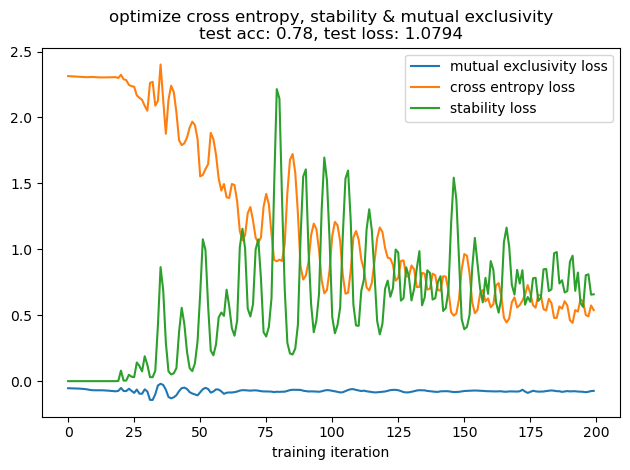

In [4]:
me_loss_weight = 0.5
st_loss_weight = 0.5
classifier = torch.load("../../monitoring/semi_supervised_losses/classifier.pkl")
classifier.me_loss_weight = me_loss_weight
classifier.st_loss_weight = st_loss_weight
train_eval(
    classifier=classifier,
    n_iters=n_iters,
    file="both",
    title="optimize cross entropy, stability & mutual exclusivity")

# cross entropy

iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
iter 200


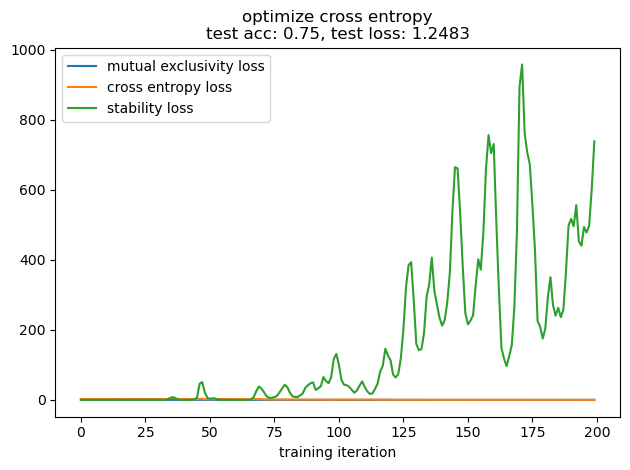

In [5]:
me_loss_weight = 0
st_loss_weight = 0
classifier = torch.load("../../monitoring/semi_supervised_losses/classifier.pkl")
classifier.me_loss_weight = me_loss_weight
classifier.st_loss_weight = st_loss_weight
train_eval(
    classifier=classifier,
    n_iters=n_iters,
    file="vanilla",
    title="optimize cross entropy")

# cross entropy & stability

iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
iter 200


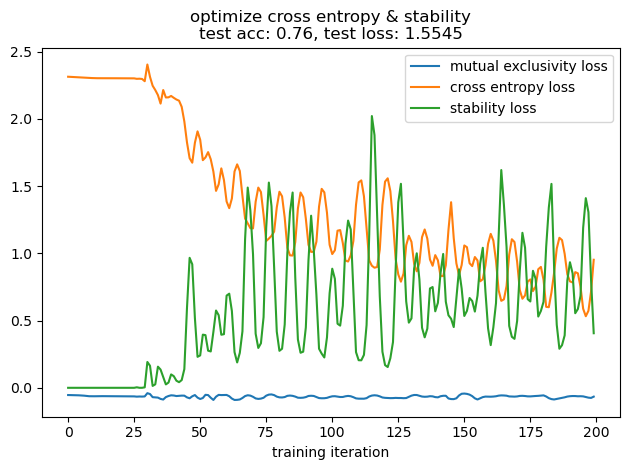

In [6]:
me_loss_weight = 0
st_loss_weight = 0.5
classifier = torch.load("../../monitoring/semi_supervised_losses/classifier.pkl")
classifier.me_loss_weight = me_loss_weight
classifier.st_loss_weight = st_loss_weight
train_eval(
    classifier=classifier,
    n_iters=n_iters,
    file="st",
    title="optimize cross entropy & stability")

# cross entropy & mutual exclusivity

iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
iter 200


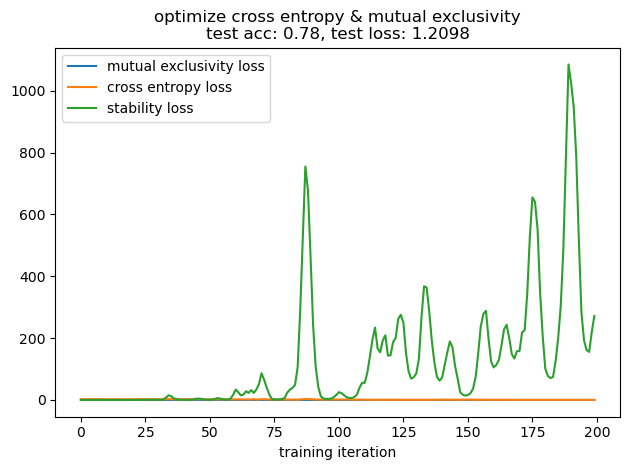

In [7]:
me_loss_weight = 0.5
st_loss_weight = 0
classifier = torch.load("../../monitoring/semi_supervised_losses/classifier.pkl")
classifier.me_loss_weight = me_loss_weight
classifier.st_loss_weight = st_loss_weight
train_eval(
    classifier=classifier,
    n_iters=n_iters,
    file="me",
    title="optimize cross entropy & mutual exclusivity")

\begin{tabular}{cccc}
  \text{optimized loss} & \text{ce} & \text{ce + st} & \text{ce + me} & \text{ce + me + st} \\
  \hline
  \text{test ce}  & 1.2483 & 1.5545 & 1.2098 & \bf{1.0794} \\
  \text{test acc}  & 0.75 & 0.76 & \bf{0.78} & \bf{0.78} \\
\end{tabular}

# conclusions
- if stability loss is not optimized, classifier makes vastly different predictions for differently augmented versions of the same input (augmented by dropout in the input layer)
- optimizing mutual exclusivity loss additionally to cross entropy leads to significantly lower test error
- optimizing mutual exclusivity loss and stability loss additionally to cross entropy leads to another significant improvement of the test loss